# Labor 6

## A) LPC Analyse Vokal f und a 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython
import wave
import scipy.signal as signal
import sounddevice as sd
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.signal.windows import hamming

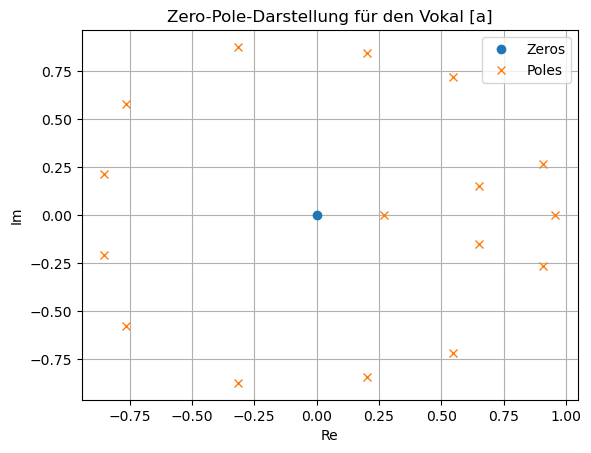

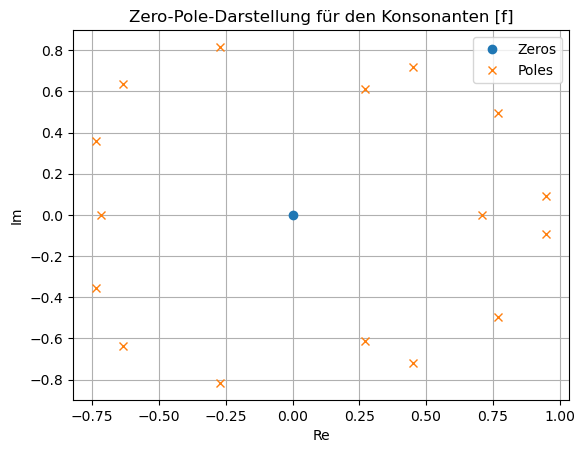

In [2]:
# Signal laden und Ausschnitt abschneiden 
durationSeconds = 0.2
data, sr = librosa.load("audio/a.wav", sr=None, mono=False)
segment_a = librosa.util.fix_length(data, size=int(sr * durationSeconds))
data, sr = librosa.load("audio/f.wav", sr=None, mono=False)
segment_f = librosa.util.fix_length(data, size=int(sr * durationSeconds))

# LPC-Analyse
L = 16  # Prädiktorordnung

def lpc_analysis(segment, L):
    a = librosa.lpc(segment, order=L)
    return a

a_a = lpc_analysis(segment_a, L)
a_f = lpc_analysis(segment_f, L)

# Inverser Filter
def inverse_filter(a, segment):
    return signal.lfilter(a, [1.0], segment)

e_a = inverse_filter(a_a, segment_a)
e_f = inverse_filter(a_f, segment_f)

# Synthesefilter
def synthesis_filter(a, e, segment):
    b = [1.0]
    return signal.lfilter(b, a, e)

y_syn_a = synthesis_filter(a_a, e_a, segment_a)
y_syn_f = synthesis_filter(a_f, e_f, segment_f)

# Zero-Pole-Darstellung
def plot_zeros_poles(a, title):
    zeros, poles, _ = signal.tf2zpk([1, 0], a)
    plt.figure()
    plt.plot(np.real(zeros), np.imag(zeros), 'o', label='Zeros')
    plt.plot(np.real(poles), np.imag(poles), 'x', label='Poles')
    plt.title(title)
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.legend()
    plt.grid()
    plt.show()

plot_zeros_poles(a_a, 'Zero-Pole-Darstellung für den Vokal [a]')
plot_zeros_poles(a_f, 'Zero-Pole-Darstellung für den Konsonanten [f]')


### Interpretation

- Vokal **a**: Die Polstellen zeigen eine klare und regelmäßige Verteilung, was auf deutliche Formanten hinweist, die für Vokale charakteristisch sind. Da es nur eine Nullstelle bei z=0 gibt werden keine Frequenzanteile im Spektrum komplett ausgelöscht
- Konsonant **f**: Die Polstellen zeigen eine unregelmäßige Verteilung und sind weiter vom Einheitskreis entfernt, was auf weniger harmonische Formanten hinweist. Auch hier haben wir nur eine Nullstelle bei z=0.

## B) Frequenzgang des Synthesefilters

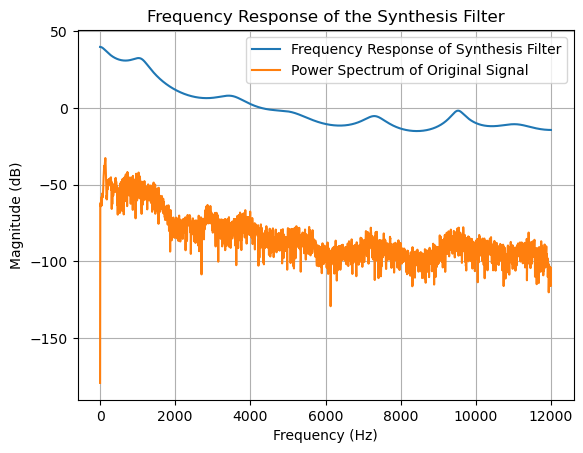

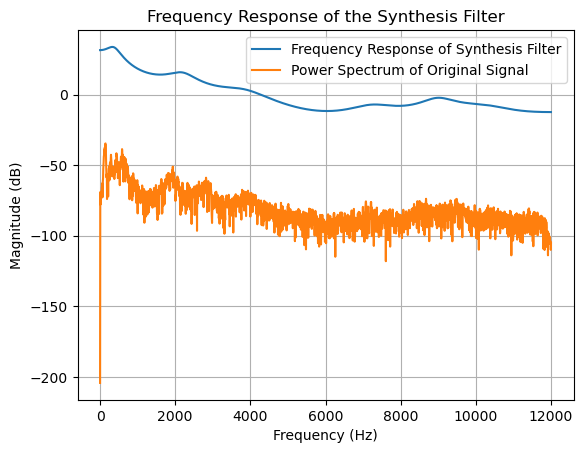

In [3]:
def frequency_response(a, y_window):
    # 8. Berechne und zeichne den Frequenzgang des Synthesefilters
    w, h = signal.freqz([1], a, worN=8000)  # worN=8000 gibt die Anzahl der Punkte für die Berechnung an

    w = w / np.pi * sr / 2  # Konvertiere w in Hz
    h_db = 20 * np.log10(np.abs(h))

    plt.figure()
    plt.plot(w, h_db, label='Frequency Response of Synthesis Filter')
    
    plt.title('Frequency Response of the Synthesis Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()

    # 9. Berechne und zeichne das Leistungsspektrum des Originalsignals
    f, Pxx = signal.periodogram(y_window, sr)
    plt.plot(f, 10 * np.log10(Pxx), label='Power Spectrum of Original Signal')
    plt.legend()
    plt.show()
    
frequency_response(a_a, segment_a)
frequency_response(a_f, segment_f)

### L=8

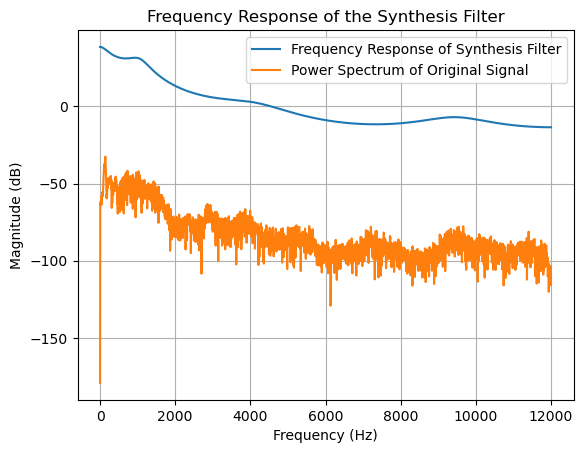

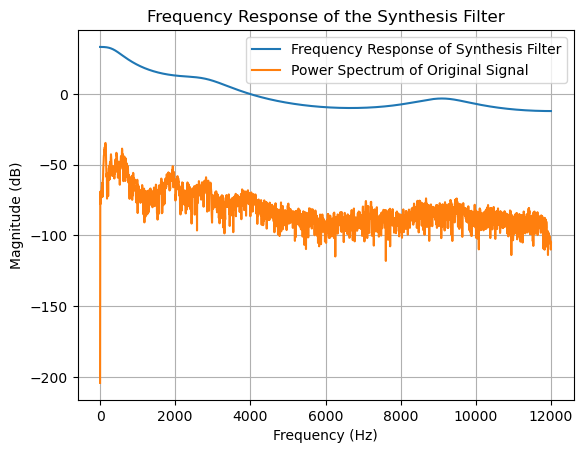

In [4]:
a_a32 = lpc_analysis(segment_a, 8)
a_f32 = lpc_analysis(segment_f, 8)
    
frequency_response(a_a32, segment_a)
frequency_response(a_f32, segment_f)

### L = 32

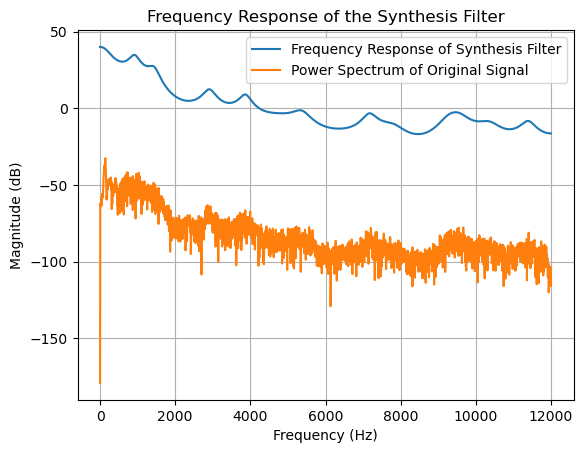

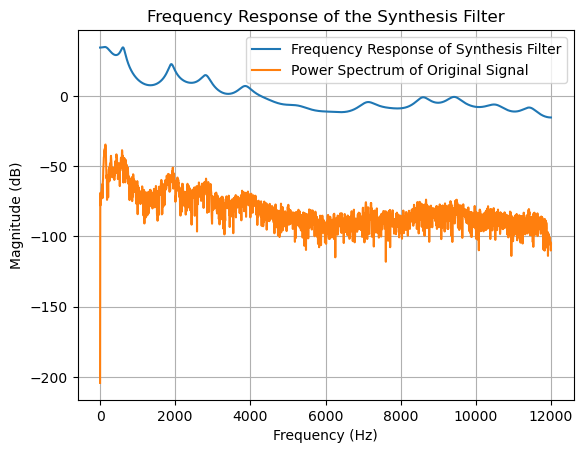

In [5]:
a_a32 = lpc_analysis(segment_a, 32)
a_f32 = lpc_analysis(segment_f, 32)
    
frequency_response(a_a32, segment_a)
frequency_response(a_f32, segment_f)


### Interpretation
Die vergrößerung der Prädikatorlänge L führt dazu, dass mehr Feinheiten im Leistungsspektrum modelliert werden. Jedoch werden diese für die Bestimmung von Lauten nicht benötigt.

## C) LPC Analyse für einen ganzen Satz

In [6]:
def lpc_analysis(signal, fs, order=12, window_size=200, window_shift=100):
    # Anzahl der Fenster berechnen
    num_windows = (len(signal) - window_size) // window_shift + 1
    lpc_matrix = np.zeros((order + 1, num_windows))  # Matrix für LPC-Koeffizienten

    # Fensterweise LPC-Analyse durchführen
    for i in range(num_windows):
        start = i * window_shift
        end = start + window_size
        windowed_signal = signal[start:end] * np.hamming(window_size)

        # LPC-Analyse durchführen
        a = librosa.lpc(windowed_signal, order=order)
        lpc_matrix[:, i] = a

    return lpc_matrix



y, fs = librosa.load('audio/Suchmaschinelpc.wav', sr=8000)  

lpc_matrix = lpc_analysis(y, fs)
print(lpc_matrix)

# Speichern der LPC-Matrix
np.save('output/lpc_matrix.npy', lpc_matrix)



[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-1.41803444 -1.0793249  -1.01470632 ...  0.          0.
   0.        ]
 [ 0.38092115 -0.01351633  0.12777443 ...  0.          0.
   0.        ]
 ...
 [-0.01686099  0.12403632  0.09750887 ...  0.          0.
   0.        ]
 [-0.02992971 -0.04894335 -0.04101614 ...  0.          0.
   0.        ]
 [ 0.00809344  0.02673674  0.04636172 ...  0.          0.
   0.        ]]


## D) Grundfrequenz f0

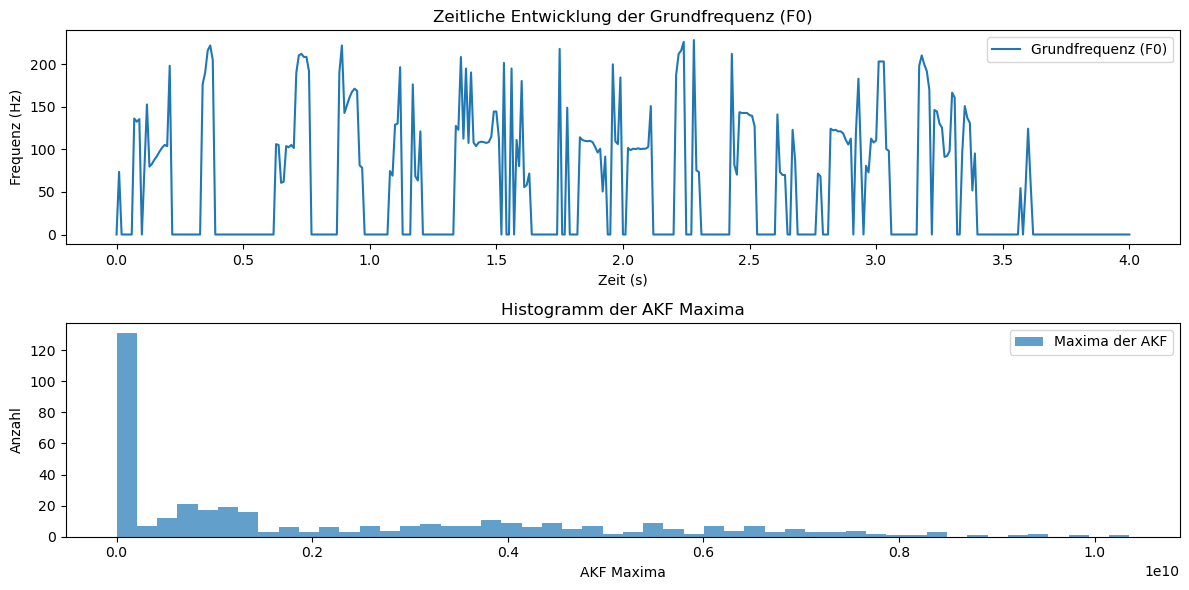

In [7]:
# Lade die Audiodatei (angenommen, der Dateipfad ist angegeben)
fs, audio_signal = wavfile.read('audio/Suchmaschinelpc.wav')

# Parameter
window_length = int(0.02 * fs)  # 20 ms Fenster
shift = int(0.01 * fs)  # 10 ms Verschiebung
min_f0 = 50  # Minimale Grundfrequenz in Hz
max_f0 = 230  # Maximale Grundfrequenz in Hz

# Fensterfunktion
window = hamming(window_length)

# Funktion zur Berechnung der AKF (Autokorrelationsfunktion)
def autocorrelation(signal):
    result = np.correlate(signal, signal, mode='full')
    return result[result.size // 2:]

# Funktion zur Bestimmung der Grundfrequenz
def find_f0(akf, fs):
    peaks, _ = find_peaks(akf)
    if len(peaks) > 1:
        lag = peaks[1]  # Erstes Peak (Null-Lag ignorieren)
        f0 = fs / lag
        if min_f0 <= f0 <= max_f0:
            return f0
    return 0

# Verarbeitung des Signals in Fenstern
num_windows = (len(audio_signal) - window_length) // shift + 1
f0_values = []
akf_maxima = []

for i in range(num_windows):
    start = i * shift
    end = start + window_length
    segment = audio_signal[start:end] * window
    akf = autocorrelation(segment)
    f0 = find_f0(akf, fs)
    f0_values.append(f0)
    akf_maxima.append(np.max(akf))

# Plotten
time_axis = np.arange(num_windows) * (shift / fs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, f0_values, label='Grundfrequenz (F0)')
plt.xlabel('Zeit (s)')
plt.ylabel('Frequenz (Hz)')
plt.title('Zeitliche Entwicklung der Grundfrequenz (F0)')
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(akf_maxima, bins=50, alpha=0.7, label='Maxima der AKF')
plt.xlabel('AKF Maxima')
plt.ylabel('Anzahl')
plt.title('Histogramm der AKF Maxima')
plt.legend()

plt.tight_layout()
plt.show()


## E) Synthese des Sprachsignals

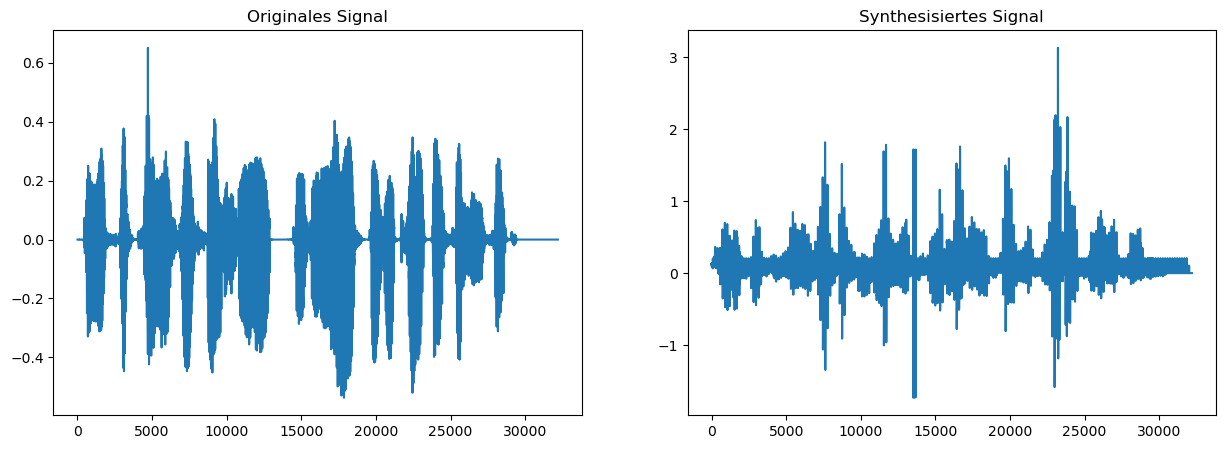

In [8]:
# Lade das Audiosignal
y, sr = librosa.load('audio/Suchmaschinelpc.wav', sr=8000)

# Definiere Parameter
w = 256  # Frame-Länge
w_shift = 164  # Schrittweite
M = 16 # LPC-Ordnung
F0 = 100  # Grundfrequenz in Hz

# Berechne LPC-Koeffizienten
frames = librosa.util.frame(y, frame_length=w, hop_length=w_shift)
lpc_coeffs = [librosa.lpc(frame, order=M) for frame in frames.T]

# Berechne Energie
E = np.sum(y ** 2) / len(y)

# Erzeuge Erregungssignal
excitation = np.zeros_like(y)
for i in range(0, len(y), int(sr / (F0))):
    excitation[i] = np.sqrt(E)

# Synthese des Signals
y_synth = np.zeros_like(y)
for i in range(len(frames.T)):
    frame_start = i * w_shift
    frame_end = frame_start + w
    if frame_end > len(y):
        break
    a = lpc_coeffs[i]
    e = excitation[frame_start:frame_end]
    y_synth[frame_start:frame_end] += signal.lfilter([1], a, e)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.title('Originales Signal')

plt.subplot(1, 2, 2)
plt.plot(y_synth)
plt.title('Synthesisiertes Signal')

plt.show()

wavfile.write('output/y_syn_a.wav', sr, y_synth.astype(np.float32))

IPython.display.Audio("output/y_syn_a.wav")


### Sprachqualität

#### Frame Länge
- Ist die Fensterlänge zu gering, gehen wichtige Abschnitte des Signals verloren, wodurch das Signal nicht flüssig wiedergegeben wird.
- Ist die Fensterlänge zu hoch, ist ein Rauschen klar erkennbar.

#### w_shift
- Bei einer zu hohen Überlappung hört sich das Signal zu stark quantisiert an.
- Bei einer zu niedrigen Überlappung hören sich die Übergänge hart an.

#### Grundfrequenz
- Bei einer zu niedrigen Grundfrequenz ist das Signal zu tief.
- Bei einer zu hohen Grundfrequenz ist das Signal zu hoch.

#### Prädiktor Ordnung M
- Bei einer zu geringen Prädiktor-Ordnung übertönt das Rauschen den gesprochenen Anteil.
- Bei einer zu hohen Prädiktor-Ordnung hört sich das Signal mechanisch an.

#### Resultierende Sprachqualität
- Es ist ein klares Rauschen im Hintergrund zu erkennen. Auch hört sich das Signal summend und mechanisch an. Dennoch wird der Satz verständlich wiedergegeben.
